# Exercício 5: BAO, 1o pico da CMB e distância angular

## Carregando os dados

In [1]:
import corner
import emcee
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cte
from scipy.integrate import quad
from scipy.optimize import minimize, brentq

%matplotlib inline

In [2]:
# Load BAO data
file = "theta_bao.dat"

z_bao, theta_deg, err_theta_deg = np.loadtxt(file, unpack=True)

theta_bao = theta_deg * np.pi / 180.
err_theta_bao = err_theta_deg * np.pi / 180.

In [3]:
# Add first peak of CMB
l_cmb = 302.
err_l_cmb = 0.2
z_ls = 1090.

theta_cmb = np.pi / l_cmb
err_theta_cmb = err_l_cmb / l_cmb * theta_cmb

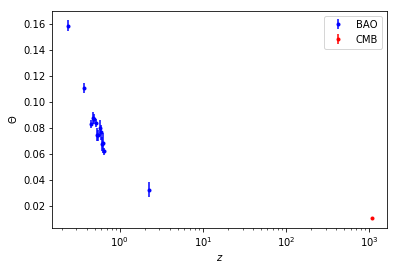

In [4]:
# Check plot
plt.xscale("log")
plt.ylabel(r"$\Theta$")
plt.xlabel(r"$z$")
plt.errorbar(z_bao, theta_bao, err_theta_bao, fmt="b.", label="BAO")
plt.errorbar(z_ls, theta_cmb, err_theta_cmb, fmt="r.", label="CMB")
plt.legend();

## Modelando $\Theta_{BAO}$ e $\Theta_{CMB}$

In [5]:
def E_inverse(z, omgM, omgR):
    Ez = np.sqrt((1 - omgM) + omgM * np.power(1 + z, 3) + omgR * np.power(1 + z, 4))
    return 1. / Ez

def sound_horizon_integrand(z, omgM, omgR, omgB, omgG):
    cs = np.power(3 + 9./4 * omgB / (omgG * z), -0.5)
    return cs * E_inverse(z, omgM, omgR)

def sound_horizon(z_star, omgM, omgR, omgB, omgG):
    integral, _ = quad(sound_horizon_integrand, z_star, np.inf, args=(omgM, omgR, omgB, omgG))
    return integral

def angular_distance(z, omgM, omgR):
    integral, _ = quad(E_inverse, 0, z, args=(omgM, omgR))
    return integral

def theta_model(z, z_star, omgM, omgR, omgB, omgG):
    return sound_horizon(z_star, omgM, omgR, omgB, omgG) / angular_distance(z, omgM, omgR)

def chisq_cmb(omgM, omgR, omgB, omgG):
    z_star_cmb = 1090
    theta_cmb_model = theta_model(z_ls, z_star_cmb, omgM, omgR, omgB, omgG)
    chisq = np.power( (theta_cmb_model - theta_cmb) / err_theta_cmb, 2 )
    return chisq

def chisq_bao(omgM, omgR, omgB, omgG):
    z_star_bao = 1060
    theta_bao_model = np.array([theta_model(z, z_star_bao, omgM, omgR, omgB, omgG) for z in z_bao])
    chisq = np.sum( np.power( (theta_bao_model - theta_bao) / err_theta_bao, 2 ) )
    return chisq

def chisq_all(omgM, omgR, omgB, omgG):
    chisq = chisq_cmb(omgM, omgR, omgB, omgG) + \
            chisq_bao(omgM, omgR, omgB, omgG)
    return chisq

In [6]:
# Fiducial parameters
omgB_fid = 0.05
omgG_fid = 5e-5
omgR_fid = 8.4e-5
omgM_fid = 0.3

## Soluções de máxima verossimilhança

#### Apenas CMB

In [7]:
# CMB only
chisq_vec_cmb = np.vectorize(lambda omgM: chisq_cmb(omgM, omgR_fid, omgB_fid, omgG_fid))
result_omgM_cmb = minimize(chisq_vec_cmb, omgM_fid, bounds=[(0.01, 1.)])
omgM_best_cmb, = result_omgM_cmb.x
min_chisq_cmb, = result_omgM_cmb.fun
print("Convergiu?: ", result_omgM_cmb.success)
print("chisq = ", min_chisq_cmb)
print("omegaM = ", omgM_best_cmb)

Convergiu?:  True
chisq =  1.4210560088881748e-11
omegaM =  0.2890148111119692


#### Apenas BAO

In [8]:
# BAO only
chisq_vec_bao = np.vectorize(lambda omgM: chisq_bao(omgM, omgR_fid, omgB_fid, omgG_fid))
result_omgM_bao = minimize(chisq_vec_bao, omgM_fid, bounds=[(0.01, 1.)])
omgM_best_bao, = result_omgM_bao.x
min_chisq_bao, = result_omgM_bao.fun
print("Convergiu?: ", result_omgM_bao.success)
print("chisq/dof = ", min_chisq_bao / (len(z_bao) - 1))
print("omegaM = ", omgM_best_bao)

Convergiu?:  True
chisq/dof =  1.155667421789302
omegaM =  0.2107731725723369


#### Ambos

In [9]:
# CMB + BAO
chisq_vec_all = np.vectorize(lambda omgM: chisq_all(omgM, omgR_fid, omgB_fid, omgG_fid))
result_omgM = minimize(chisq_vec_all, omgM_fid, bounds=[(0.01, 1.)])
omgM_best, = result_omgM.x
min_chisq_cmb, = result_omgM.fun
print("Convergiu?: ", result_omgM.success)
print("chisq / dof = ", min_chisq_cmb / len(z_bao))
print("omegaM = ", omgM_best)

Convergiu?:  True
chisq / dof =  2.1676501428759396
omegaM =  0.28873892477373475


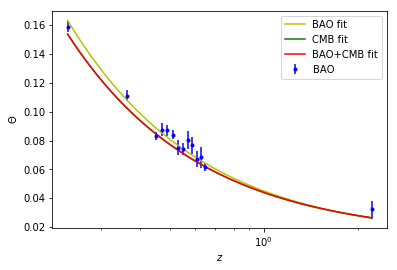

In [10]:
zs = np.linspace(z_bao.min(), z_bao.max(), 1000)
thetas_best_cmb = np.array([theta_model(z, 1060, omgM_best_cmb, omgR_fid, omgB_fid, omgG_fid) for z in zs])
thetas_best_bao = np.array([theta_model(z, 1060, omgM_best_bao, omgR_fid, omgB_fid, omgG_fid) for z in zs])
thetas_best = np.array([theta_model(z, 1060, omgM_best, omgR_fid, omgB_fid, omgG_fid) for z in zs])
#theta_cmb_cmb = theta_model(z_ls, 1090, omgM_best_cmb, omgR_fid, omgB_fid, omgG_fid)
#theta_cmb_cmb = theta_model(z_ls, 1090, omgM_best_cmb, omgR_fid, omgB_fid, omgG_fid)

plt.xscale("log")
plt.ylabel(r"$\Theta$")
plt.xlabel(r"$z$")
plt.errorbar(z_bao, theta_bao, err_theta_bao, fmt="b.", label="BAO")
#plt.errorbar(z_ls, theta_cmb, err_theta_cmb, fmt="r.", label="CMB")
plt.plot(zs, thetas_best_bao, "y", label="BAO fit")
plt.plot(zs, thetas_best_cmb, "g", label="CMB fit")
plt.plot(zs, thetas_best, "r", label="BAO+CMB fit")
plt.legend();

## Probabilidades a posteriori

### Apenas CMB

In [11]:
# Functions for priors and loglikelihoods
def lnprior_cmb(pars):
    omgM, = pars
    if 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_cmb(pars):
    omgM, = pars
    return -0.5 * chisq_cmb(omgM, omgR_fid, omgB_fid, omgG_fid)

def lnprob_cmb(pars):
    lp = lnprior_cmb(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_cmb(pars)

In [12]:
max_loglikelihood = lnprob_cmb([omgM_best_cmb])
def integral_like(oM):
    # multiply by np.exp(-lnprob_cmb([omgM_best_cmb])) to prevent numerical instability
    integral, _ = quad(lambda x: np.exp(lnprob_cmb([x]) - max_loglikelihood), 0, oM)
    return integral

# by omgM ~ 0.4 likelihood is already 0

total_int = integral_like(0.4)

# gets p percentile of posterior distribution
def omgM_percentile(p):
    perc = brentq(lambda x: integral_like(x) - p*total_int, 0., 0.4)
    return perc

omegaM_16, omegaM_50, omegaM_84 = omgM_percentile(0.16), omgM_percentile(0.5), omgM_percentile(0.84)
print("omegaM = ", omegaM_50, "(-", omegaM_50 - omegaM_16, ")(+", omegaM_84 - omegaM_50, ")")

omegaM =  0.2890221756567422 (- 0.0012663424053946937 )(+ 0.0012736210420026262 )


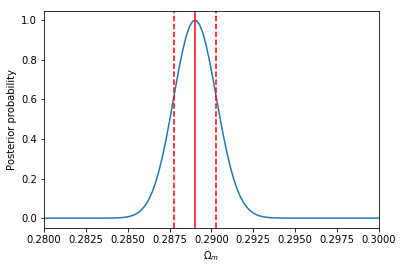

In [13]:
omgMs = np.linspace(0.28, 0.30, 100)
likelihoods = np.exp([lnprob_cmb([x]) for x in omgMs])

plt.xlabel(r"$\Omega_{m}$")
plt.ylabel(r"Posterior probability")
plt.xlim([0.28, 0.30])
plt.plot(omgMs, likelihoods)
plt.axvline(x=omegaM_16, linestyle="dashed", color="red")
plt.axvline(x=omegaM_84, linestyle="dashed", color="red")
plt.axvline(x=omegaM_50, color="red");

$\Omega_m = 0.2890^{+0.0013}_{-0.0013}$

### Apenas BAO (flat prior)

In [14]:
# Functions for priors and loglikelihoods
def lnprior_bao(pars):
    omgM, = pars
    if 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

def lnlike_bao(pars):
    omgM, = pars
    return -0.5 * chisq_bao(omgM, omgR_fid, omgB_fid, omgG_fid)

def lnprob_bao(pars):
    lp = lnprior_bao(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_bao(pars)

In [15]:
max_loglikelihood = lnprob_bao([omgM_best_bao])
def integral_like(oM):
    # multiply by np.exp(-lnprob_bao([omgM_best_bao])) to prevent numerical instability
    integral, _ = quad(lambda x: np.exp(lnprob_bao([x]) - max_loglikelihood), 0, oM)
    return integral

# by omgM 1.0 posterior is 0

total_int = integral_like(1.0)

# gets p percentile of posterior distribution
def omgM_percentile(p):
    perc = brentq(lambda x: integral_like(x) - p*total_int, 0.1, 1.0)
    return perc

omegaM_16, omegaM_50, omegaM_84 = omgM_percentile(0.16), omgM_percentile(0.5), omgM_percentile(0.84)
print("omegaM = ", omegaM_50, "(-", omegaM_50 - omegaM_16, ")(+", omegaM_84 - omegaM_50, ")")

omegaM =  0.2120122245023539 (- 0.01661679027645227 )(+ 0.017848306530959812 )


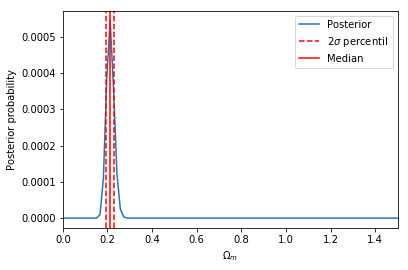

In [16]:
omgMs = np.linspace(0.00, 1.5, 100)
posterior = np.exp([lnprob_bao([x]) for x in omgMs])

plt.xlabel(r"$\Omega_{m}$")
plt.ylabel(r"Posterior probability")
plt.xlim([0.0, 1.5])
plt.plot(omgMs, posterior, label="Posterior")
plt.axvline(x=omegaM_16, linestyle="dashed", color="red")
plt.axvline(x=omegaM_84, linestyle="dashed", color="red", label=r"2$\sigma$ percentil")
plt.axvline(x=omegaM_50, color="red", label="Median")
plt.legend();

$\Omega_{m} = 0.21^{+0.02}_{-0.02}$

### BAO + CMB

In [17]:
# Prior for BAO + CMB (flat)
def lnprior_all(pars):
    omgM, = pars
    if 0.0 < omgM < 1.0:
        return 0.0
    return -np.inf

# Log likelihood for BAO + CMB
def lnlike_all(pars):
    omgM, = pars
    return -0.5 * chisq_all(omgM, omgR_fid, omgB_fid, omgG_fid)

# Log posterior for BAO + CMB
def lnprob_all(pars):
    lp = lnprior_all(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_all(pars)


In [18]:
max_loglikelihood = lnprob_all([omgM_best])
def integral_like(oM):
    # multiply by np.exp(-lnprob_all([omgM_best])) to prevent numerical instability
    integral, _ = quad(lambda x: np.exp(lnprob_all([x]) - max_loglikelihood), 0, oM)
    return integral

# by omgM 1.0 posterior is 0

total_int = integral_like(1.0)

# gets p percentile of posterior distribution
def omgM_percentile(p):
    perc = brentq(lambda x: integral_like(x) - p*total_int, 0.1, 1.0)
    return perc

omegaM_16, omegaM_50, omegaM_84 = omgM_percentile(0.16), omgM_percentile(0.5), omgM_percentile(0.84)
print("omegaM = ", omegaM_50, "(-", omegaM_50 - omegaM_16, ")(+", omegaM_84 - omegaM_50, ")")

omegaM =  0.2887462464120079 (- 0.0012626521320152628 )(+ 0.6923925666249553 )


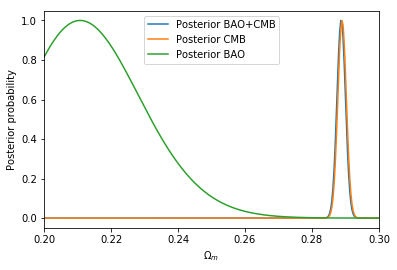

In [28]:
omgMs = np.linspace(0.28, 0.30, 100)

posterior_all = np.exp([lnprob_all([x]) for x in omgMs])
posterior_cmb = np.exp([lnprob_cmb([x]) for x in omgMs])
posterior_bao = np.exp([lnprob_bao([x]) for x in omgMs])

plt.xlabel(r"$\Omega_{m}$")
plt.ylabel(r"Posterior probability")
plt.xlim([0.20, 0.30])

plt.plot(omgMs, posterior_all/posterior_all.max(), label="Posterior BAO+CMB")
plt.plot(omgMs, posterior_cmb/posterior_cmb.max(), label="Posterior CMB")
plt.plot(omgMs, posterior_bao/posterior_bao.max(), label="Posterior BAO")

plt.legend();